In [10]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Seed 고정
SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [11]:
len(tf.config.list_physical_devices("GPU"))

1

In [12]:
X=np.load("../../data/processed/03_AIHUB_dataset/X_eye.npy")
y=np.load("../../data/processed/03_AIHUB_dataset/y_eye.npy")

print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (164762, 40, 80, 1)
y.shape: (164762,)


In [13]:
from collections import Counter
import os

base_dir="../../data/processed/03_AIHUB_dataset/cropped_data"
open_cnt=len(os.listdir(os.path.join(base_dir, "open")))
closed_cnt=len(os.listdir(os.path.join(base_dir, "closed")))

print("Open:", open_cnt)
print("Closed:", closed_cnt)

Open: 95213
Closed: 69549


In [18]:
IMG_SIZE=(40, 80)
BATCH_SIZE=64
DATA_PATH="../../data/processed/03_AIHUB_dataset/cropped_data"

# ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator=train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 131811 images belonging to 2 classes.
Found 32951 images belonging to 2 classes.


In [19]:
model=Sequential([
    Conv2D(32, kernel_size=3, activation="relu", padding="same", input_shape=(40, 80, 1)),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Conv2D(64, kernel_size=3, activation="relu", padding="same"),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),

    Conv2D(128, kernel_size=3, activation="relu", padding="same"),
    MaxPooling2D(pool_size=2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [20]:
save_dir="temp_model/07_cnn_l2"
os.makedirs(save_dir, exist_ok=True)

checkpoint=ModelCheckpoint(filepath=os.path.join(save_dir, "best_model.keras"),
                           save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

es=EarlyStopping(monitor="val_loss", patience=10,
                 restore_best_weights=True, verbose=1)

In [21]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=30, callbacks=[checkpoint, es])

Epoch 1/30


2025-06-16 15:49:30.108343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2060/2060 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.7233
Epoch 1: val_accuracy improved from -inf to 0.84547, saving model to temp_model/07_cnn_l2/best_model.keras
2060/2060 [==============================] - 62s 30ms/step - loss: 0.5876 - accuracy: 0.7233 - val_loss: 0.4150 - val_accuracy: 0.8455
Epoch 2/30
2058/2060 [============================>.] - ETA: 0s - loss: 0.4955 - accuracy: 0.7963
Epoch 2: val_accuracy improved from 0.84547 to 0.85400, saving model to temp_model/07_cnn_l2/best_model.keras
2060/2060 [==============================] - 61s 29ms/step - loss: 0.4955 - accuracy: 0.7963 - val_loss: 0.3925 - val_accuracy: 0.8540
Epoch 3/30
1152/2060 [===============>..............] - ETA: 21s - loss: 0.4752 - accuracy: 0.8079

KeyboardInterrupt: 

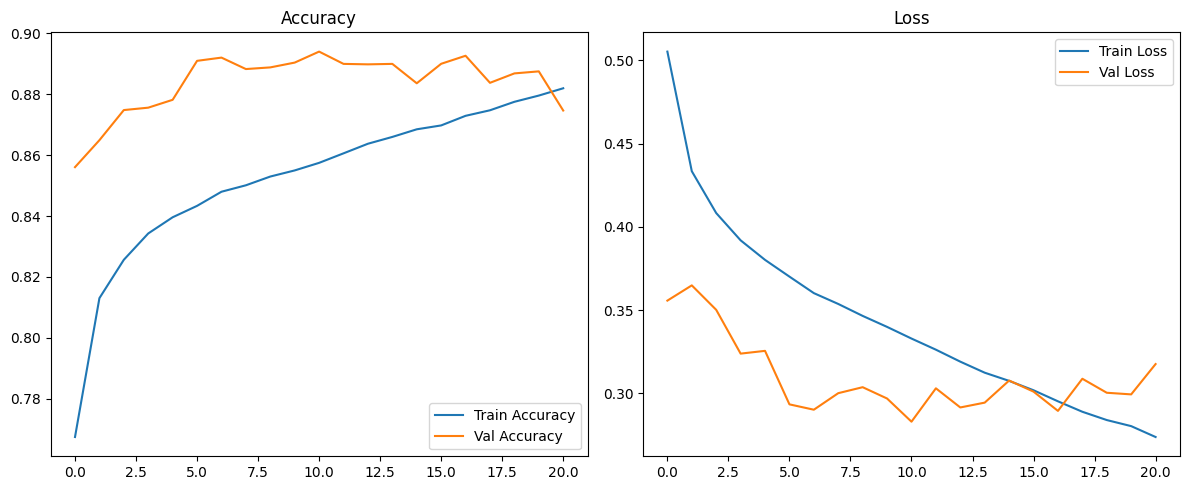

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()

# ResNet50V2 모델 정의

In [4]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base_model=ResNet50V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))
base_model.trainable=False  # 전이학습 backbone freeze

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.3)(x)  # 줄임
x=Dense(64, activation="relu")(x)
x=Dropout(0.15)(x)  # 줄임
output=Dense(1, activation="sigmoid")(x)

model=Model(inputs=base_model.input, outputs=output)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

2025-06-16 01:32:43.247272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-16 01:32:43.247360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-16 01:32:43.247396: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-16 01:32:43.506076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-16 01:32:43.506132: I external/local_xla/xla/stream_executor

In [6]:
esc=EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
checkpoint=ModelCheckpoint(filepath="temp_model/04_dropout_tuned/best_model.keras",
                           monitor="val_loss", save_best_only=True, verbose=1)

In [7]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=30, callbacks=[esc, reduce_lr, checkpoint], verbose=1)

Epoch 1/30


2025-06-16 01:33:32.583539: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-16 01:33:32.727404: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-16 01:33:32.727443: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-16 01:33:32.727535: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-16 01:33:34.073672: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-16 01:33:34.073708: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

   1/4120 [..............................] - ETA: 4:03:09 - loss: 1.1669 - accuracy: 0.5312

2025-06-16 01:33:34.543561: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ea8d0442490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-16 01:33:34.543591: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-06-16 01:33:34.549860: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-16 01:33:34.586348: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:408] Couldn't read CUDA driver version.
I0000 00:00:1750005214.595430   23090 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4119/4120 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.8127
Epoch 1: val_loss improved from inf to 0.35194, saving model to temp_model/04_dropout_tuned/best_model.keras
4120/4120 [==============================] - 79s 18ms/step - loss: 0.4376 - accuracy: 0.8127 - val_loss: 0.3519 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 2/30
4116/4120 [============================>.] - ETA: 0s - loss: 0.4148 - accuracy: 0.8225
Epoch 2: val_loss improved from 0.35194 to 0.33746, saving model to temp_model/04_dropout_tuned/best_model.keras
4120/4120 [==============================] - 59s 14ms/step - loss: 0.4148 - accuracy: 0.8225 - val_loss: 0.3375 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 3/30
4120/4120 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.8268
Epoch 3: val_loss did not improve from 0.33746
4120/4120 [==============================] - 59s 14ms/step - loss: 0.4075 - accuracy: 0.8268 - val_loss: 0.3415 - val_accuracy: 0.8731 - lr: 0.0010
Epoc

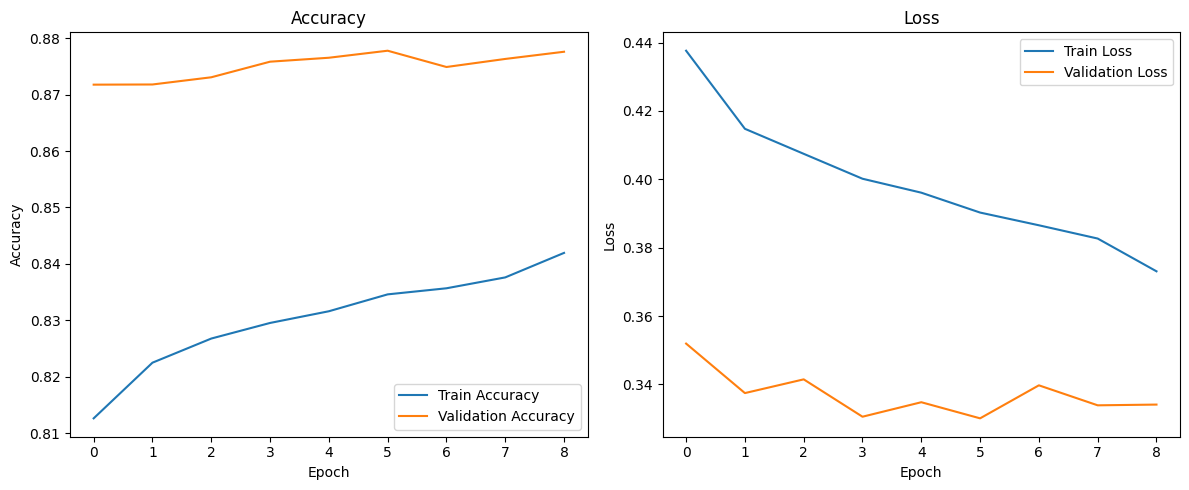

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
# os.makedirs("../../results/images", exist_ok=True)
# plt.savefig("../../results/images/03_final_training_plot.png")
plt.show()

1030/1030 [==============================] - 10s 9ms/step
              precision    recall  f1-score   support

        Open       0.91      0.79      0.84     13909
      Closed       0.86      0.95      0.90     19042

    accuracy                           0.88     32951
   macro avg       0.89      0.87      0.87     32951
weighted avg       0.88      0.88      0.88     32951



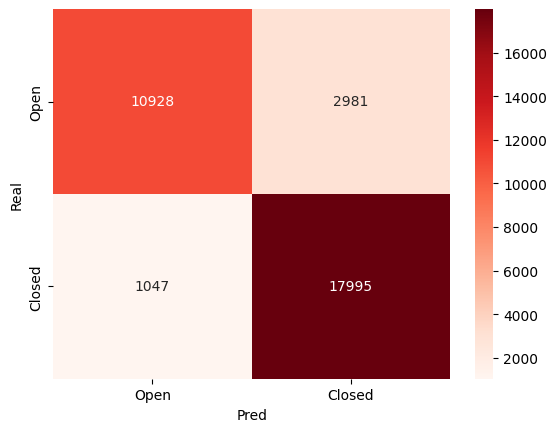

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_generator.reset()
preds=model.predict(val_generator)
pred_labels=(preds > 0.5).astype(int)
true_labels=val_generator.classes

report=classification_report(true_labels, pred_labels, target_names=["Open", "Closed"])
print(report)

conf_matrix=confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Open", "Closed"], yticklabels=["Open", "Closed"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

# fine-tuning

In [10]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# base_model 불러오고 unfrozen 처리
base_model=ResNet50V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Fine-tuning을 위해 마지막 N개 블록만 trainable
for layer in base_model.layers[:-30]:  # 예: 마지막 30개만 푼다
    layer.trainable=False
for layer in base_model.layers[-30:]:
    layer.trainable=True

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.3)(x)
x=Dense(64, activation="relu")(x)
x=Dropout(0.15)(x)
output=Dense(1, activation="sigmoid")(x)

model=Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

esc=EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
checkpoint=ModelCheckpoint(filepath="temp_model/05_finetuned_resnet/best_model.keras",
                           monitor="val_loss", save_best_only=True, verbose=1)

history=model.fit(train_generator, validation_data=val_generator,
                  epochs=20, callbacks=[esc, reduce_lr, checkpoint], verbose=1)

Epoch 1/20
4119/4120 [============================>.] - ETA: 0s - loss: 0.4451 - accuracy: 0.8036
Epoch 1: val_loss improved from inf to 0.31368, saving model to temp_model/05_finetuned_resnet/best_model.keras
4120/4120 [==============================] - 104s 24ms/step - loss: 0.4451 - accuracy: 0.8036 - val_loss: 0.3137 - val_accuracy: 0.8858 - lr: 1.0000e-05
Epoch 2/20
4119/4120 [============================>.] - ETA: 0s - loss: 0.3432 - accuracy: 0.8548
Epoch 2: val_loss improved from 0.31368 to 0.29934, saving model to temp_model/05_finetuned_resnet/best_model.keras
4120/4120 [==============================] - 96s 23ms/step - loss: 0.3432 - accuracy: 0.8548 - val_loss: 0.2993 - val_accuracy: 0.8888 - lr: 1.0000e-05
Epoch 3/20
4119/4120 [============================>.] - ETA: 0s - loss: 0.2786 - accuracy: 0.8795
Epoch 3: val_loss did not improve from 0.29934
4120/4120 [==============================] - 95s 23ms/step - loss: 0.2786 - accuracy: 0.8795 - val_loss: 0.3138 - val_accuracy